## Spooky Author Detection
### Assignment 6 - module 6 (Improvement of module 5 assignment)
### Bob Owens

In [76]:
'''
Imports if necessary
Depends on the platform you are using, i.e., local vs Colab vs Docker
'''
# !pip install --upgrade pip
# !pip install plotly
# spark.stop()

'\nImports if necessary\nDepends on the platform you are using, i.e., local vs Colab vs Docker\n'

In [77]:
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession
from pyspark.sql import functions as func
from pyspark.sql.functions import length, col, min, size, split


import os
import pandas as pd
import numpy as np

import warnings

# Suppress all python warnings
warnings.filterwarnings('ignore')


# Suppress all pysaprk warnings.  Errors will remain.
import logging
logger = logging.getLogger('py4j')
logger.setLevel(logging.ERROR)


## Stage 0: Import Data

In [78]:
data_base_path = './data/spooky-author-identification'
os.listdir(data_base_path)

['test', 'test.zip', 'train', 'sample_submission.zip', 'train.zip']

In [79]:
# Get data from zipped files
from io import BytesIO, TextIOWrapper
from zipfile import ZipFile

# function to unzip the file and place it in a folder in the base data dir
def unzip(file):
    file_name = os.path.basename(file)
    new_name, _ = os.path.splitext(file_name)

    with ZipFile(file, 'r') as zip_file:
        zip_file.extractall(data_base_path +'/' + new_name)
                    

In [80]:
# unzip the data files 
unzip('./data/spooky-author-identification/train.zip')
# unzip('./data/spooky-author-identification/test.zip')
os.listdir(data_base_path)

['test', 'test.zip', 'train', 'sample_submission.zip', 'train.zip']

In [81]:
# create a new spark session
conf = SparkConf().setAppName("spooky_authors").setMaster("local")
sc = SparkContext.getOrCreate(conf)
sc.setLogLevel("ERROR")

spark = SparkSession.builder.config(conf=conf).getOrCreate()

In [82]:
#read the csv into a spark dataframe
data = spark.read.csv(
    data_base_path+'/train/'+'train.csv', 
    header=True,
    inferSchema=True,
    escape='"'
)

data = data.withColumn("text", func.regexp_replace("text", '"', ''))

data.createOrReplaceTempView("spooky_sentences")

# review the columns
print(f"Columns:\t{data.columns}", end='\n')

Columns:	['id', 'text', 'author']


### Reverse Engineer Query to Run

In [83]:
result_df=spark.sql(
    '''
    SELECT 
        text AS sentence,
        size(split(text, ' ')) AS word_count
    FROM
        spooky_sentences
    ORDER BY 
        word_count DESC
    
    '''
         )

result_df.show(10, truncate=True)

+--------------------+----------+
|            sentence|word_count|
+--------------------+----------+
|Diotima approache...|       861|
|Oh no I will beco...|       594|
|They are gone for...|       445|
|To chambers of pa...|       377|
|As for those who ...|       335|
|Burning with the ...|       267|
|I have much to sa...|       256|
|I invited him to ...|       191|
|Oh God help me Le...|       190|
|It was in Rome th...|       186|
+--------------------+----------+
only showing top 10 rows



### Subquery to Count Total Words by Author

In [84]:
'''
This can be accomplished in two ways.  One with SQL using subqueries and the other using one SQL query
then grouping and aggregating with pyspark.sql function

Expected Result
+------+-----------+
|author|total_words|
+------+-----------+
|   EAP|     200995|
|   MWS|     165710|
|   HPL|     156651|
+------+-----------+
'''

# sub_query_df = spark.sql(
#     '''
#     WITH spooky_sub_sentences as (
#         SELECT
#             author,
#             size(split(text, ' ')) AS word_count
#         FROM
#             spooky_sentences  
#     )
    
#     SELECT 
#         author,
#         SUM(word_count) AS total_words
#     FROM 
#         spooky_sub_sentences
#     GROUP BY 
#         author
#     ORDER BY 
#         SUM(word_count) DESC
#     '''

# )



sub_query_df = spark.sql('''
    SELECT 
        author,
        SUM(size(split(text, ' '))) AS total_words
    FROM 
        spooky_sentences
    GROUP BY 
        author
    ORDER BY 
        SUM(size(split(text, ' '))) DESC
''')

sub_query_df = sub_query_df.groupby('author').sum().orderBy('sum(total_words)', ascending=False)

sub_query_df.show()

+------+----------------+
|author|sum(total_words)|
+------+----------------+
|   EAP|          200995|
|   MWS|          165710|
|   HPL|          156651|
+------+----------------+



## Stage 1: Exploratory Data Analysis

In [85]:
# check distinct number of authors -- should be 3
authors = data.groupBy('author').count().orderBy('count',ascending=False)
authors.show()

min_count=authors.agg(min("count")).collect()[0][0]

# seperate the data by classes
eap_df = data.filter(col('author')=='EAP')
mws_df = data.filter(col('author')=='MWS')
hpl_df = data.filter(col('author')=='HPL')

eap_df=eap_df.sample(False, min_count/eap_df.count(), seed=42)
mws_df=mws_df.sample(False, min_count/mws_df.count(), seed=42)
# hpl_df=hpl_df.sample(False, min_count/hpl_df.count(), seed=42)

data = eap_df.union(mws_df).union(hpl_df)
authors = data.groupBy('author').count().orderBy('count',ascending=False)
print("After undersampling")
authors.show()

+------+-----+
|author|count|
+------+-----+
|   EAP| 7900|
|   MWS| 6044|
|   HPL| 5635|
+------+-----+

After undersampling
+------+-----+
|author|count|
+------+-----+
|   EAP| 5747|
|   HPL| 5635|
|   MWS| 5627|
+------+-----+



In [86]:
# descriptive stats on the text columns of the dataframe
# add a column for text length
data = data.withColumn('text_length', length(data['text']))


# descriptive stats on text length
desc_stats=data.groupBy('author') \
    .agg(
        func.count('*').alias('text_count'),
        func.min('text_length').alias('min_text_length'),
        func.max('text_length').alias('max_text_length'),
        func.avg('text_length').alias('avg_text_length')
    
)
desc_stats.show()

# # rows where text length are 21 exactly.
# print("Rows where the text length is '21' exactly.")
# data.select('*').filter(col("text_length")==21).show(truncate=False)

# descriptive stats for entire dataframe
summary_stats = data.describe()


# deal with null values
data = data.na.drop()

import plotly.express as px

df = data.toPandas()

#  Plot data in a box and whiskers chart
fig = px.box(df, x="author", y="text_length", points="all")
fig.update_layout(title='Text Length Among Authors')
fig.show()

# using 1.5 * IQR to drop outliers
q1, q3 = data.approxQuantile('text_length', [0.25, 0.75], 0)
iqr = q3 - q1

lower_bound = q1 - 1.5 * iqr
upper_bound = q3 + 1.5 * iqr

# filter out outliers more than 1.5 IQR from central tendency
data = data.filter(
    (col("text_length") <=  upper_bound) & (col("text_length") >=  lower_bound)
)

df = data.toPandas()

#  Plot data after dropping outliers in a box and whiskers chart
fig = px.box(df, x="author", y="text_length", points="all")
fig.update_layout(title='Text Length Among Authors After Dropping Outliers')
fig.show()

+------+----------+---------------+---------------+------------------+
|author|text_count|min_text_length|max_text_length|   avg_text_length|
+------+----------+---------------+---------------+------------------+
|   EAP|      5747|             19|           1505| 142.0913520097442|
|   MWS|      5627|             20|           3048|150.75795272791896|
|   HPL|      5635|             21|            900|155.75244010647737|
+------+----------+---------------+---------------+------------------+



## Stage 2: Feature Extraction 

In [87]:
# Lemmatization of words in text
from pyspark.sql.functions import pandas_udf, PandasUDFType
from pyspark.sql.types import StringType
from nltk.stem import WordNetLemmatizer
import nltk

# using wordnet to lemmatize text
# download wordnet
nltk.download('wordnet')
nltk.download('omw-1.4')

# custom function to lemmatize text.  
# text is in a series so must adjust function to accept series
# cannot just pass text assuming it is a string
def lemmatize(text_series):
    lemm = WordNetLemmatizer()
    return text_series.apply(lambda text: ' '.join([lemm.lemmatize(x) for x in text.split()]))


# custom pandas function to apply to pyspark df
lemm_udf = pandas_udf(lemmatize, returnType=StringType())

# add column with lemmatize data
data = data.withColumn('lemmatized_txt', lemm_udf('text'))

data.show()

[nltk_data] Downloading package wordnet to /Users/Bob/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/Bob/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


+-------+--------------------+------+-----------+--------------------+
|     id|                text|author|text_length|      lemmatized_txt|
+-------+--------------------+------+-----------+--------------------+
|id26305|This process, how...|   EAP|        231|This process, how...|
|id11008|In his left hand ...|   EAP|        200|In his left hand ...|
|id13515|The surcingle hun...|   EAP|         43|The surcingle hun...|
|id16607|Here we barricade...|   EAP|         63|Here we barricade...|
|id08441|To these speeches...|   EAP|        340|To these speech t...|
|id18925|On every hand was...|   EAP|        115|On every hand wa ...|
|id01704|These bizarre att...|   EAP|         78|These bizarre att...|
|id15222|Meantime the whol...|   EAP|         60|Meantime the whol...|
|id19576|The present pecul...|   EAP|        289|The present pecul...|
|id21136|It is not to be s...|   EAP|        146|It is not to be s...|
|id11523|Presently the mur...|   EAP|        247|Presently the mur...|
|id221

In [88]:
## word 2 vec

from pyspark.ml.feature import Tokenizer, Word2Vec

tokenizer = Tokenizer(inputCol="text", outputCol="words")
data = tokenizer.transform(data)

word2Vec = Word2Vec(vectorSize=20, seed=42, inputCol="words", outputCol="word2vec")
data = word2Vec.fit(data).transform(data)

In [90]:
# data.show(2)

23/07/23 10:53:31 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:00:56 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:01:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:01:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:02:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:02:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:02:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:03:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:03:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:03:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:04:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:04:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:04:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:05:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:05:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 11:48:23 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 12:04:45 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 13:16:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 13:17:06 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 13:17:26 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 13:17:46 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 13:53:28 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 14:23:05 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 14:58:54 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 15:52:14 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

23/07/23 17:27:52 ERROR Inbox: Ignoring error
org.apache.spark.SparkException: Exception thrown in awaitResult: 
	at org.apache.spark.util.ThreadUtils$.awaitResult(ThreadUtils.scala:322)
	at org.apache.spark.rpc.RpcTimeout.awaitResult(RpcTimeout.scala:75)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRefByURI(RpcEnv.scala:102)
	at org.apache.spark.rpc.RpcEnv.setupEndpointRef(RpcEnv.scala:110)
	at org.apache.spark.util.RpcUtils$.makeDriverRef(RpcUtils.scala:36)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.driverEndpoint$lzycompute(BlockManagerMasterEndpoint.scala:117)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.org$apache$spark$storage$BlockManagerMasterEndpoint$$driverEndpoint(BlockManagerMasterEndpoint.scala:116)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$lzycompute$1(BlockManagerMasterEndpoint.scala:611)
	at org.apache.spark.storage.BlockManagerMasterEndpoint.isExecutorAlive$1(BlockManagerMasterEndpoint.scala:610)
	at org.apache.spar

### Custom function to categorize authors according to text length. 

In [42]:
# custom function to categorize authors according to text.  
# text is in a series so must adjust function to accept series
# cannot just pass text assuming it is a string
def author_category(wrd_cnt):
    
    return wrd_cnt.apply(
        lambda x: "wordy" if x > 30 else (
            "pity" if x < 7 else "not wordy"
        )
    )

# custom pandas function to apply to pyspark df
auth_cat_udf = pandas_udf(author_category, returnType=StringType())

# add column with author_category data
data = data.withColumn('author_category', auth_cat_udf('text_length'))

word_count=data.groupBy('author_category').count().orderBy('count',ascending=False)
word_count.show()

+---------------+-----+
|author_category|count|
+---------------+-----+
|          wordy|15934|
|      not wordy|  451|
+---------------+-----+



### Combine All Text Into One String by Author

In [43]:
from pyspark.sql.functions import collect_list, concat_ws

combined_text = data.groupBy('author').agg(concat_ws(", ", collect_list("text")).alias("combined_text"))

combined_text.show(truncate=True)

+------+--------------------+
|author|       combined_text|
+------+--------------------+
|   EAP|This process, how...|
|   MWS|How lovely is spr...|
|   HPL|It never once occ...|
+------+--------------------+



### Example sentence by author with greater than 30 words

In [44]:
greater_than_30_words = spark.sql('''
    with thirty_words as (SELECT 
        author
        ,size(split(text, ' ')) AS text_length
        ,text
        ,ROW_NUMBER() OVER (
                PARTITION BY author ORDER BY size(split(text, ' '))
                ) AS row_number
    FROM 
        spooky_sentences
    WHERE 
        size(split(text, ' ')) > 30
    )
    
    SELECT 
        author
        ,text
    FROM 
        thirty_words
    WHERE row_number = 1
''')

greater_than_30_words.show(truncate=True)

+------+--------------------+
|author|                text|
+------+--------------------+
|   EAP|I seemed to be up...|
|   HPL|Wilbur's growth w...|
|   MWS|My lieutenant, fo...|
+------+--------------------+



### Calculating Lexical Density

In [45]:
data.createOrReplaceTempView("dataset_table")

#Perform SQL query to compare lexical density across authors
query4 = """
SELECT author, COUNT(DISTINCT word) / CAST(SUM(size(split(text, ' '))) AS FLOAT) AS lexical_density
FROM (
    SELECT author, explode(split(lower(text), ' ')) AS word, text
    FROM dataset_table
) subquery
GROUP BY author
ORDER BY lexical_density DESC
"""
lexical_density_comparison = spark.sql(query4)
lexical_density_comparison.show()

+------+--------------------+
|author|     lexical_density|
+------+--------------------+
|   EAP|0.004816779939992942|
|   HPL|0.004320116828586388|
|   MWS|0.003948718727051327|
+------+--------------------+



In [46]:
# lexical density
data = data.join(lexical_density_comparison, on='author', how='inner')
# number of words in text
data = data.withColumn('num_words', size(split(data['text'], ' ')))
# lexical density times the number of words in the text
data = data.withColumn('density_x_words', data['lexical_density']*data['num_words'])

lex_dens = data.groupBy('author').agg({'lexical_density':'average'}).orderBy('avg(lexical_density)',ascending=False)
lex_dens.show(truncate=True)

+------+--------------------+
|author|avg(lexical_density)|
+------+--------------------+
|   EAP|0.004816779939993208|
|   HPL|0.004320116828586615|
|   MWS|0.003948718727051...|
+------+--------------------+



### Data Prep/Processing

In [47]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.ml.feature import CountVectorizer, IDF
from pyspark.ml.feature import Normalizer, OneHotEncoder, StringIndexer
from pyspark.ml import Pipeline

In [48]:
# Feature Extraction
# Step 1: Tokenization
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")
# Step 2: Stop word removal
stopwords_remover = StopWordsRemover(inputCol="tokens", outputCol="filtered_tokens")
# Step 3: TF-IDF calculation
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")
# Step 4: Normalization
normalizer = Normalizer(inputCol="tfidf", outputCol="normalized_features")
# Step 5: Encoding the labels
indexer = StringIndexer(inputCol='author', outputCol='idx_author')
encoder = OneHotEncoder(inputCol='idx_author', outputCol='enc_author')
# Step 5a: Encoding author category
indexer1 = StringIndexer(inputCol='author_category', outputCol='idx_author_category')
encoder1 = OneHotEncoder(inputCol='idx_author_category', outputCol='enc_author_category')
# Step 5: Create pipeline for chaining the text mining transformers
pipeline = Pipeline(stages=[
    tokenizer, 
    stopwords_remover, 
    vectorizer, 
    idf, 
    normalizer, 
    indexer, 
    encoder,
    indexer1, 
    encoder1
])
# Step 6: Apply the pipeline to DataFrame
processed_data = pipeline.fit(data).transform(data)

print("Author encoding")
encoded_authors=processed_data.select('author','idx_author').distinct().show(truncate=False)
# processed_data.columns
print("Author category encoding")
encoded_categories=processed_data.select('author_category','idx_author_category').distinct().show(truncate=False)

processed_data.columns

Author encoding
+------+----------+
|author|idx_author|
+------+----------+
|EAP   |1.0       |
|MWS   |2.0       |
|HPL   |0.0       |
+------+----------+

Author category encoding
+---------------+-------------------+
|author_category|idx_author_category|
+---------------+-------------------+
|not wordy      |1.0                |
|wordy          |0.0                |
+---------------+-------------------+



['author',
 'id',
 'text',
 'text_length',
 'lemmatized_txt',
 'words',
 'word2vec',
 'author_category',
 'lexical_density',
 'num_words',
 'density_x_words',
 'tokens',
 'filtered_tokens',
 'vectorized_tokens',
 'tfidf',
 'normalized_features',
 'idx_author',
 'enc_author',
 'idx_author_category',
 'enc_author_category']

In [52]:
from pyspark.ml.feature import VectorAssembler
from pyspark.mllib.evaluation import MulticlassMetrics
import matplotlib.pyplot as plt
import seaborn as sns

# train, validation set split
assembler = VectorAssembler(
    inputCols=[
        "text_length", "tfidf","normalized_features",'lexical_density',
        'idx_author_category', 'num_words','density_x_words', 'word2vec'
    ], 
    outputCol="features")
prepared_data = assembler.transform(processed_data)

#Split the data into training and test sets for supervised learning
train_data, val_data, test_data = prepared_data.randomSplit([0.7, 0.2, 0.1], seed=42)

## Stage 3: Machine Learning

In [53]:
# ML models
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import RegressionEvaluator, MulticlassClassificationEvaluator

model_eval=RegressionEvaluator(metricName="rmse",labelCol="idx_author")

lr = LogisticRegression(featuresCol='features',labelCol="idx_author")

lr_model = lr.fit(train_data)
# predictions on validation set
preds=lr_model.transform(val_data)

## Stage 4: Evaluation and Visualization

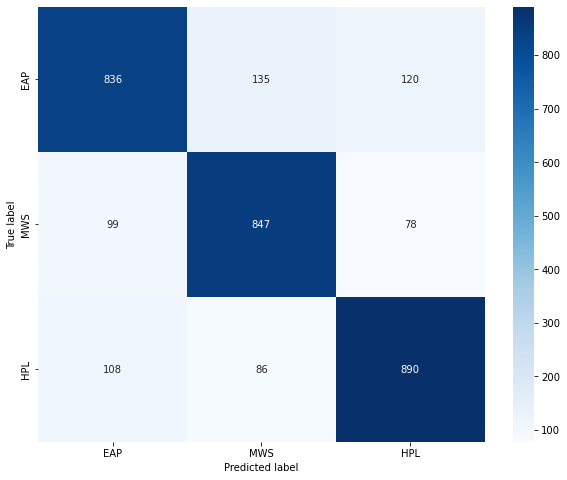

Accuracy: 0.8043138480775243
Weighted Precision: 0.8044096417127633
Weighted Recall: 0.8043138480775243
Weighted F1 Score: 0.8041108314489867


In [54]:
# compute confusion matrix
predictionAndLabels = preds.select("prediction", "idx_author").rdd
metrics = MulticlassMetrics(predictionAndLabels)
confusion_matrix = metrics.confusionMatrix().toArray()

# add back in labels for matrix
x_labels = ['EAP', 'MWS', 'HPL']
y_labels = ['EAP', 'MWS', 'HPL']

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix, annot=True, cmap='Blues', fmt='.0f', xticklabels=x_labels, yticklabels=y_labels)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Test statistics
# Compute accuracy
accuracy_evaluator = MulticlassClassificationEvaluator(labelCol="idx_author", predictionCol="prediction", metricName="accuracy")
accuracy = accuracy_evaluator.evaluate(preds)

# Compute weighted precision
precision_evaluator = MulticlassClassificationEvaluator(labelCol="idx_author", predictionCol="prediction", metricName="weightedPrecision")
weighted_precision = precision_evaluator.evaluate(preds)

# Compute weighted recall
recall_evaluator = MulticlassClassificationEvaluator(labelCol="idx_author", predictionCol="prediction", metricName="weightedRecall")
weighted_recall = recall_evaluator.evaluate(preds)

# Compute weighted f1 score
f1_evaluator = MulticlassClassificationEvaluator(labelCol="idx_author", predictionCol="prediction", metricName="f1")
weighted_f1_score = f1_evaluator.evaluate(preds)

# Print the results
print(f"Accuracy: {accuracy}")
print(f"Weighted Precision: {weighted_precision}")
print(f"Weighted Recall: {weighted_recall}")
print(f"Weighted F1 Score: {weighted_f1_score}")


## Next Steps


Learnings
1. After the text was processed including, dropping rows, dropping nulls, balancing the datasets by author, adding lexical density analysis, and one other column the accuracy improved to just over 80%.

Next Steps
1. Try additional models.
2. Hypertune the parameters.
3. Explore word2vec as a way to create additional context around the text.
   - Can this be used as a feature to indicate how educated the authors could be?
4. Would a transformer produce better results? I might need access to a GPU for this.


In [23]:
# spark.stop()